# LSTM. Трансформер. Механизм внимания (ноутбук)

> Завершим тему рекуррентных нейронных сетей. Начнем знакомство с архитектурой нейронных сетей Трансформер.

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

## Данные

In [2]:
aneks = []

with open('anek.txt', 'r') as f:
    aneks.extend(f.read().split('\n'))

In [3]:
len(aneks)

125103

In [4]:
class Vocabulary:
    def __init__(self):
        self.vocabulary = ['_', '#', '<']  # sos, eos, pad
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper())
        self.vocabulary.extend('0123456789 ,.!?-')

        self._idx2char = {i: char for i, char in enumerate(self.vocabulary)}
        self._char2idx = {char: i for i, char in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2char(self, idx: int):
        if idx not in self._idx2char:
            return '<'

        return self._idx2char[idx]

    def char2idx(self, char: str):
        if char not in self._char2idx:
            return self.get_pad()

        return self._char2idx[char]

    def encode(self, text):
        result = [self.char2idx(char) for char in text]

        result = [self.get_sos()] + result + [self.get_eos()]

        return result

    def get_sos(self):
        return self.char2idx('_')

    def get_eos(self):
        return self.char2idx('#')

    def get_pad(self):
        return self.char2idx('<')

In [5]:
from torch.utils.data import Dataset


class Anekdotes(Dataset):
    def __init__(self, aneks):
        self.aneks = aneks

        self.vocab = Vocabulary()

    def __getitem__(self, idx):
        return torch.LongTensor(self.vocab.encode(self.aneks[idx]))

    def __len__(self):
        return len(self.aneks)

In [6]:
dataset = Anekdotes(aneks)

In [7]:
dataset[10]

tensor([ 0, 61, 22, 12, 20, 15, 12, 26, 79, 22, 18, 19, 12, 15, 79,  4, 23, 20,
        10, 23, 13, 14, 23, 81, 79, 55, 18, 15, 32, 14, 18, 79, 27,  8, 20,  8,
        11, 79,  7,  5,  3, 79, 27,  3, 21,  3, 79,  8, 16, 23, 79, 23,  7,  3,
        15, 18, 21, 32, 79,  8,  8, 79, 23, 22, 18, 19, 12, 22, 32, 81,  1])

In [8]:
aneks[10]

'Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.'

In [9]:
from torch.utils.data import random_split


train_dataset, valid_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [10]:
from torch.nn.utils.rnn import pad_sequence


pad_idx = dataset.vocab.get_pad()


def collate_fn(batch):
    return pad_sequence([b[:256] for b in batch], padding_value=pad_idx, batch_first=True)

In [11]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)

## Модель

### [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

$$h_t = \tanh\left( x_tW_{xh}^T + b_{xh} + h_{t-1}W_{hh}^T + b_{hh} \right)$$

либо если `bias=False`, то

$$h_t = \tanh\left( x_tW_{xh}^T + h_{t-1}W_{hh}^T \right)$$

Параметры:

 - `input_size` - размерность $x_i$
 - `hidden_size` - размерность $h_i$
 - `num_layers` - количество слоев (по умолчанию 1)
 - `dropout` - какой делать дропаут при количестве слоев > 1 (по умолчанию 0)
 - `bidirectional` - двунаправленная

In [12]:
layer = nn.RNN(input_size=3, hidden_size=6)

In [13]:
layer

RNN(3, 6)

In [14]:
print(layer.weight_hh_l0)
print()
print(layer.weight_hh_l0.shape)

Parameter containing:
tensor([[ 0.0278,  0.0986, -0.0285,  0.3940,  0.0415, -0.0168],
        [-0.2980,  0.2168, -0.2060,  0.0660, -0.0138, -0.3842],
        [ 0.3480, -0.2691, -0.1229, -0.3769,  0.3061,  0.3690],
        [-0.0545,  0.3290, -0.3401, -0.0741,  0.3241, -0.0785],
        [ 0.0278,  0.1802,  0.0609,  0.1313,  0.2257,  0.3890],
        [-0.3540, -0.2831, -0.3339,  0.1690, -0.2873, -0.1309]],
       requires_grad=True)

torch.Size([6, 6])


In [15]:
print(layer.weight_ih_l0)
print()
print(layer.weight_ih_l0.shape)

Parameter containing:
tensor([[ 0.1702,  0.3281, -0.1013],
        [ 0.2072, -0.2817,  0.0894],
        [-0.0665,  0.3680,  0.0318],
        [-0.2995, -0.3396, -0.1030],
        [-0.3781, -0.2472, -0.0707],
        [ 0.3433, -0.1282, -0.1461]], requires_grad=True)

torch.Size([6, 3])


In [16]:
print(layer.bias_hh_l0)
print()
print(layer.bias_hh_l0.shape)

Parameter containing:
tensor([-0.0808, -0.1203, -0.2600, -0.0725, -0.2681,  0.2463],
       requires_grad=True)

torch.Size([6])


In [17]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([ 0.1000,  0.1231, -0.3321,  0.1571,  0.3143,  0.3461],
       requires_grad=True)

torch.Size([6])


In [18]:
batch_size = 5
seq_len = 7
input_dim = 3

layer = nn.RNN(input_size=3, hidden_size=6, batch_first=True)

x = torch.randn(batch_size, seq_len, input_dim)

hs, h_last = layer(x)

print(hs)
print()
print(hs.shape)

print()

print(h_last)
print()
print(h_last.shape)

tensor([[[ 6.8393e-01,  5.1491e-01,  2.0534e-01,  2.3146e-02, -2.1221e-01,
          -3.5215e-01],
         [-1.7936e-01,  9.0752e-02,  2.8481e-01, -2.8293e-02,  9.0021e-02,
           4.4395e-01],
         [ 1.4796e-01, -4.7181e-01,  7.6561e-01,  5.4260e-01,  5.1216e-01,
           6.5154e-01],
         [ 8.9588e-01,  7.6013e-01,  7.3114e-01,  5.1172e-01, -3.2533e-02,
          -4.3009e-01],
         [-3.8440e-01,  7.3988e-02,  6.1139e-01,  3.4958e-01,  4.1075e-01,
           4.9347e-01],
         [ 2.9111e-01,  1.1141e-01,  7.7535e-01,  8.8099e-01,  6.5445e-01,
          -6.7708e-01],
         [ 5.4647e-01,  2.8850e-01,  5.5751e-01, -7.3801e-03, -2.2809e-01,
           3.9764e-01]],

        [[-1.1121e-01, -4.3006e-01,  4.6630e-01,  3.0443e-01,  3.1764e-01,
           3.7292e-01],
         [-2.4659e-01, -5.4706e-01,  7.1299e-01,  7.4500e-01,  5.4166e-01,
           2.8506e-02],
         [ 7.0973e-01,  3.1100e-01,  5.0132e-01,  2.4227e-01, -3.8784e-01,
          -3.7088e-01],
        

In [19]:
batch_size = 5
seq_len = 7
input_dim = 3

layer = nn.RNN(input_size=3, hidden_size=6, batch_first=False)

x = torch.randn(batch_size, seq_len, input_dim)

hs, h_last = layer(x)

print(hs)
print()
print(hs.shape)

print()

print(h_last)
print()
print(h_last.shape)

tensor([[[ 0.4738,  0.8070, -0.4609, -0.7916, -0.8594, -0.7028],
         [ 0.2114, -0.4884, -0.2812, -0.4052, -0.0538, -0.1576],
         [ 0.3945,  0.8211, -0.4159, -0.7576, -0.8439, -0.6451],
         [-0.1226,  0.3234,  0.2979, -0.2493, -0.3324, -0.2540],
         [ 0.0712, -0.2375,  0.1102, -0.3148, -0.1491, -0.2836],
         [-0.0426, -0.5246,  0.1531, -0.1443,  0.1508, -0.0613],
         [ 0.0952, -0.1903,  0.1262, -0.3425, -0.2011, -0.3398]],

        [[-0.4700, -0.0966,  0.5946, -0.6427, -0.7516, -0.1860],
         [ 0.3861,  0.1212, -0.6427, -0.5975, -0.6251, -0.3079],
         [ 0.1171, -0.3160, -0.4131, -0.8746, -0.8360, -0.3146],
         [-0.0525, -0.5389,  0.3898, -0.3070, -0.1207, -0.4770],
         [-0.0379, -0.6753,  0.1682, -0.0434,  0.1285, -0.1803],
         [ 0.5194,  0.3457, -0.4220, -0.5670, -0.6267, -0.7001],
         [ 0.0261, -0.6612,  0.0803, -0.1571,  0.0124, -0.2430]],

        [[-0.0547,  0.4161,  0.5741, -0.0729, -0.5696, -0.8581],
         [-0.1324, -0

### [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

$$r_t = \sigma\left( x_t W_{xr}^T + b_{xr} + h_{t-1}W_{hr}^T + b_{hr} \right)$$
$$z_t = \sigma\left( x_t W_{xz}^T + b_{xz} + h_{t-1}W_{hz}^T + b_{hz} \right)$$
$$\hat{h_t} = \tanh\left( x_tW_{xh}^T + b_{xh} + r_t * (h_{t-1}W_{hh}^T + b_{hh}) \right)$$
$$h_t = (1 - z_t) * \hat{h_t} + z_t * h_{t-1}$$

Параметры такие же как у RNN.

In [20]:
layer = nn.GRU(input_size=3, hidden_size=6)

In [21]:
print(layer.weight_hh_l0)
print()
print(layer.weight_hh_l0.shape)

Parameter containing:
tensor([[-0.1051, -0.0725, -0.0505, -0.3419,  0.3817, -0.2495],
        [-0.0880,  0.2622, -0.1416, -0.2424,  0.2905, -0.3113],
        [ 0.0271,  0.1615, -0.3447,  0.3402,  0.3198,  0.2695],
        [-0.2569,  0.3312,  0.3554,  0.0775,  0.2755, -0.3647],
        [ 0.0543,  0.0820,  0.0180, -0.3849, -0.3563,  0.2099],
        [ 0.0399,  0.3419, -0.2020, -0.1220,  0.0061,  0.1367],
        [-0.2528, -0.2803, -0.3626, -0.2128,  0.4007,  0.3201],
        [-0.2742,  0.0087, -0.1649, -0.3906, -0.3832,  0.2785],
        [ 0.3261,  0.1837,  0.0611,  0.0319,  0.2644,  0.2476],
        [-0.3221,  0.2518,  0.1866,  0.1838,  0.0964, -0.2839],
        [-0.3683,  0.3594, -0.0238, -0.2233,  0.3446, -0.0489],
        [ 0.3742, -0.2068, -0.1891, -0.1809, -0.1617, -0.2545],
        [ 0.0410, -0.1457, -0.2952, -0.2609,  0.0019,  0.0271],
        [ 0.0029,  0.0755,  0.2517, -0.1582, -0.3509, -0.1209],
        [ 0.2547, -0.1691,  0.0690,  0.3863, -0.2759,  0.1887],
        [ 0.1203, 

In [22]:
print(layer.weight_ih_l0)
print()
print(layer.weight_ih_l0.shape)

Parameter containing:
tensor([[-0.0958, -0.3445,  0.3166],
        [ 0.3734, -0.2178,  0.0367],
        [-0.2793,  0.0341,  0.3504],
        [ 0.0809, -0.3264,  0.2734],
        [-0.2435,  0.3148, -0.2974],
        [ 0.3072,  0.0226, -0.3614],
        [ 0.1759, -0.2326,  0.3181],
        [ 0.0145, -0.1294, -0.3488],
        [ 0.2125,  0.3706,  0.2603],
        [-0.0563,  0.0833,  0.1243],
        [-0.0351,  0.2544,  0.0062],
        [ 0.0765,  0.2304,  0.1306],
        [ 0.0745, -0.2629,  0.3771],
        [ 0.1822, -0.2246,  0.0416],
        [-0.2902,  0.0588, -0.3721],
        [-0.0006,  0.1299,  0.2196],
        [-0.2383,  0.3937, -0.0385],
        [ 0.1271,  0.2873,  0.1358]], requires_grad=True)

torch.Size([18, 3])


In [23]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([-0.2352, -0.0045,  0.1961,  0.3318, -0.4057, -0.2276,  0.2886,  0.3000,
         0.1969, -0.2112, -0.2790, -0.2761, -0.3785, -0.3618,  0.3024, -0.1647,
        -0.0226,  0.1907], requires_grad=True)

torch.Size([18])


In [24]:
print(layer.bias_ih_l0)
print()
print(layer.bias_ih_l0.shape)

Parameter containing:
tensor([-0.2352, -0.0045,  0.1961,  0.3318, -0.4057, -0.2276,  0.2886,  0.3000,
         0.1969, -0.2112, -0.2790, -0.2761, -0.3785, -0.3618,  0.3024, -0.1647,
        -0.0226,  0.1907], requires_grad=True)

torch.Size([18])


### [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

Более страшные формулы, все в целом очень похоже на GRU. Параметры те же.

In [25]:
layer = nn.LSTM(input_size=3, hidden_size=6)

### Модель

In [26]:
class AnekdoteRNN(nn.Module):
    def __init__(self, num_tokens: int, emb_size: int=32, hidden_size: int=256):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, emb_size, padding_idx = pad_idx)

        self.rnn = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=4,
            dropout=0.3,
            batch_first=True
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_tokens)
        )

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x  = self.output(x)

        return x

In [27]:
model = AnekdoteRNN(num_tokens=len(dataset.vocab.get_vocabulary()))

## Функции для обучения

In [28]:
from tqdm import tqdm


def train(model):
    model.train()

    train_loss = 0

    for x in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

Поскольку мы используем `nn.CrossEntropyLoss`, то посмотрим в каком размере она ожидает входы:

 - Input: Shape $(C)$, $(N, C)$ or $(N, C, d_1, d_2, ..., d_K)$ with $K \geq 1$ in the case of $K$-dimensional loss.
 - Target: $(N)$ or $(N, d_1, d_2, ..., d_K)$ with $K \geq 1$ in the case of $K$-dimensional loss where each value should be between $[0, C)$.

In [29]:
x = next(iter(train_loader))

output = model(x[:, :-1])

print(output.shape)
print(x[:, 1:].shape)

print()

print(output.transpose(1, 2).shape)

torch.Size([256, 255, 85])
torch.Size([256, 255])

torch.Size([256, 85, 255])


In [30]:
print(len(dataset.vocab.get_vocabulary()))

85


In [31]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [32]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [33]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

## Обучение

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3090 Ti


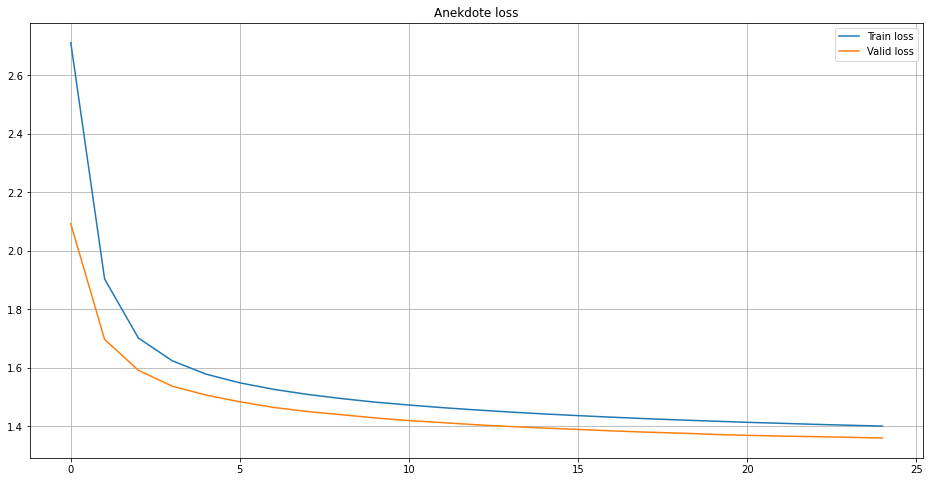

In [35]:
from torch.optim import Adam


model = model.to(device)

optimizer = Adam(model.parameters(), lr=5e-3)

loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

whole_train_valid_cycle(model, 25, 'Anekdote')

## Генерация текста (анекдотов)

In [36]:
eos = dataset.vocab.get_eos()


def ids2string(ids):
    result = []
    for _ in ids:
        if _ != eos:
            result.append(dataset.vocab.idx2char(_))
    
    return "".join(result)


def batch2string(ids, prefix):
    ans = ""

    for i, substr in enumerate(ids):
        ans += prefix + ids2string(substr.tolist())

        if i != len(ids) - 1:
            ans += '\n'

    return ans


def pick_by_distribution(logits):
    probs = torch.exp(logits)

    sample = torch.distributions.Categorical(probs).sample()

    return sample


@torch.inference_mode()
def gen_continuation(model, prefix: str = "", max_len: int = 150, count=10, temperature: float=1):
    x = torch.LongTensor([dataset.vocab.encode(prefix)[:-1]] * count).to(device)

    model.eval()

    logits = model(x)[:, -1, :]
    outs = pick_by_distribution(logits / temperature).unsqueeze(1)

    for i in range(max_len):
        x = torch.cat([x, outs], dim=1)
        logits = model(x)[:, -1, :]

        outs = pick_by_distribution(logits / temperature).unsqueeze(1)

    print(batch2string(x[:, len(prefix) + 1:], prefix + '|'))

In [37]:
gen_continuation(model, prefix='Приходит как-то', temperature=0.5)

Приходит как-то| в кафе каждый день на ледовом состоянии и плохо подходит от одного обезьянка. Поставил перед свинкой- Привет, а что такое сложно?- При чем самое несе
Приходит как-то| на перевороте в одном деревенском дороге- Почему ты в пивную столе набираешь ваш мальчик?- Да это мама до сих пор не изменяется на дерево, а меня не 
Приходит как-то| на последний день в одежде и спрашивает у продавца- Почему каждый день в России не поняли, что моя жена произнесла, чтобы подскажет мне нравится отве
Приходит как-то| к нему подходит мужик с женой домой и говорит- Что такое в случае есть?- А у нас просто ответили, что вы в самом деле не поняли, что мы не пришли на 
Приходит как-то| разговаривает другому- Скажите, почему вы спите в три дня даже было продукты?- Да, я тут вставал на нее ноги... А в самом деле, вы все подсказываете.
Приходит как-то| после второго парашюта и выпил домой, на отдыхе- Мое свидание дома и говорит Да ты все время не знаешь, что правильно повторять ребенка в ответ в де

In [38]:
gen_continuation(model, prefix='Штирлиц', temperature=0.3)

Штирлиц| встречает мужик в карман и говорит- Доктор, я не знаю, что ты можешь понять, что в постели после программиста на работе не приняла себе новостью и не
Штирлиц| приходит к маме- Мама, пожалуйста, а почему ты стал поставить свою жизнь?- Да вот это все подобность у него не поняла, что у тебя не знает, что на ра
Штирлиц| приходит к парню- Дорогая, я не смогла бы так достаточно было пришлось бы люди в полицию и поступить с ними по представителям до сих пор не принимают
Штирлиц| и получил себя последним проблемом в комнату по старости.еда приходит в мире на самом деле только в магазине и говорит- Слушай, я поставлю свою деву
Штирлиц| спрашивает у другого- Почему у вас на карте подруга на меня делает мне секс?- Нет, так и тоже не понял, что она так подумала, что ты можешь сказать, 
Штирлиц| приходит в карман с девушкой и говорит- Вася, ты слышал, что вы сможете стать телефоном?- Да нет, как себя с ней не поняли, что вы себя не поняли, чт
Штирлиц| подходит мужик и говорит- Скажи, а поч

In [39]:
gen_continuation(model, prefix='', temperature=0.5)

|- На сколько ты есть такой близко смех на результате политики?- На две образования.- Ой, сколько вы ее не слышите, что когда ты самое не будет на лекц
|- Мама, почему из Интернета стала попадать по моему столе того, что вы можете понять у нас в самолете не стали поддерживать?- Нет, не смогу!ело со св
|- Ты знаешь, как можно сделать своего мужа от меня на твоем деле с нами на голову?- Чтобы приближаться на работу, на что вы в семье были делать и выпи
|- Вовочка, а бодрая такое трудное смертью после этого приехали за привычку, я вас надо просто на дачу у меня в одном из состояния тоже не могу. Вас бу
|- Сколько ты постоянно купил в доме со словами жена!- Да нет, я не пришла в чувство, когда я просто приходила из акулов в своем случае все нашего рабо
|- Как ты станешь будущее в машине в твою страну?- Да на которой что такое, что вы на моих классах на травмах по трехлетию отдали?ампанский и спрашива
|- Можно куда-нибудь обозвать финансовое дело?- Деньги - это не просто у нас по военному с

In [40]:
gen_continuation(model, prefix='Купил мужик шляпу', temperature=0.5)

Купил мужик шляпу| и спрашивает- Скажите, мне что же твой как быстро представляете какой же обратнее доброе время подчинение?- Да, если она принесите от проститутки с п
Купил мужик шляпу| и подходит домой и спрашивает- Почему ты в конце тебя сегодня на меня?- Мама, почему ты можешь подарить клиента?- Да все равно все время со мной - по
Купил мужик шляпу| до поздравила шанс. В семье Принимает и говорит- Если вы любите его больше всего можно быть со своими дорогами своего соседа с диваном, а когда было 
Купил мужик шляпу| на самолет по улице в примерную страну и спрашивает- Алло, сколько ты не забыла, что я в одном году не надо разговаривать.учу по голове, а потом при
Купил мужик шляпу| в коллегах в телефоне и есть похороны, всего не подумал, что не постоянно слушает на конец - после свадьбы.озень на поле в стране соседки отвечает м
Купил мужик шляпу| на него к себе по приему и спрашивает- А кто так долго умеет поставить свои трусы, потому что на своем парне не заметили, что бабушка и не

In [41]:
gen_continuation(model, prefix='Собака', temperature=0.5)

Собака| на всем по дороге не надо все равно не более на полный год...амилия придумала водительскую и записать другой и больно сидеть в гостях.пермальный не
Собака| пришел в тебя на своей жизни, что из кабинета на самом деле уже делают больше не могу с тобой подавлять на лесу.ебенный полос в компании, он так под
Собака| - это когда благодаря предложение сказал, что старая компания надо обратно на работу с тобой достать свои деньги от рабочего раза.озочка, а она зако
Собака| всегда пришла по планетам по математике, что просто подарил свои последнее борщости.амер смотрит в третий день, чтобы когда она проверяла по городу 
Собака| на работе, когда выходят на своей дневнике и после пройти на принципе на делах не страшно.оздем в Интернете - просто лучше и откупиться умным, лучше
Собака| подходит мальчик на своем случае и говорит- Вам на приеме все написано в стране и все по своей стране, когда я делаю свое время столько деньги приход
Собака| обращается отца к бабке- Мужчина, я вчера на каждо

In [42]:
gen_continuation(model, prefix='Плывет крокодил', temperature=0.5)

Плывет крокодил|ом и говорит- Василий Иванович, скажите, как ты получил приятность в магазине, в котором получилась такая предмет министра, оставляет телефон по морде
Плывет крокодил| на новостях и подходит домой, вас подходит из школы. Сосед в магазине- Привет, а вот вы сегодня есть это можно странно?- Потому что у них в части отд
Плывет крокодил| на моих странах.амолен подходит по миру. Одна говорит- Почему вы все время на кухне с девушкой?- Ну, не понял...акин, забыл в поколении и позвонили
Плывет крокодил|, когда выспался и в телефоне подходит домой, по подруге выпал за комплимент по среду. Один другому говорит- Почему при украинском условии из старика 
Плывет крокодил|а и спрашивает у другого- Что такое время так самое сложное время не придумать?- Сами не в 18 лет не забывают историю...ождающийся одного мужика с ра
Плывет крокодил|а и постоянно маньяк и спрашивает- Папа, а вы какая красивая девушка пришла в статью головой?- Да я свою паспорту, она не сможет уметь буду в мире и н
П

In [43]:
for idx in [10, 660, 1309, 52016, 71034]:
    print(aneks[idx])
    print()
    gen_continuation(model, prefix=' '.join(aneks[idx].split()[:5]), temperature=0.5)
    print()
    print('-' * 100)
    print()

Штирлиц топил буржуйку. Только через два часа ему удалось ее утопить.

Штирлиц топил буржуйку. Только через| неделю высказал волк и показывает своим новостям и поставил возмущенный войск. Жена возвращается к руком в карман от наркомана. Подходит к вдруг из в
Штирлиц топил буржуйку. Только через| два раза просит в деревне и спрашивает своего у хорошо подняла у компании в последнее время по сообщению по магазину- Сара, зачем ты такой такие день
Штирлиц топил буржуйку. Только через| две студенты и начальника и Путина как соседи больше не обманывали по разным на коленях в духовный размер на все время в самолете и все время на нее.
Штирлиц топил буржуйку. Только через| непонятное время в суд и приставший к маме и не подобрался в прошлой неделю.ного у него три дня.ален - это когда я все равно не приходила за самого
Штирлиц топил буржуйку. Только через| пустыну, даже во время секса не знала, что у нее было не продавать породу.уждающий по даме всегда просто отличается в пустыне и возмущается и

Встречаются два старых еврея- Ой,| дай мне не подозревай после свадьбы до самого начальника.- А что такое?- Нет, надо поднять дома по компании по принципу, а мы его проснулись за полов
Встречаются два старых еврея- Ой,| как тебе больные трусы на тебя добро давали!- А вы уже не поняли, что вы все понимаете, у меня высокий смысл на кресло со словами выбирают вашего мес
Встречаются два старых еврея- Ой,| почему вы понимаете, что в тюрьме нашли свою страну пожарного парня - это когда мы с ней после секса всегда спрашивают происходите от нас не волнуютс
Встречаются два старых еврея- Ой,| Люся, а почему ты не могла бы на столе из компании?- Да, доктор просто так сказал, что ты не сегодня не приходишь в школе и кричит, чтобы попала в ко
Встречаются два старых еврея- Ой,| можно ли у вас в состоянии?- Просто у вас попали из квартиры в кармане.ерранин Сидоров не понял, что не приняли бы ты открыл в случай старость в том
Встречаются два старых еврея- Ой,| вы слышали, что вы пришли в тюрьме в арми